## ESE 101: Programming Module 5
### Radiation: Surface Radiative Fluxes
#### Dave Bonan, Jordan Benjamin, Tapio Schneider

In this module, you will plot surface radiative fluxes, describe key features of the Earth's radiative balance at the surface, and calculate the transport of heat done by the atmopshere and ocean. Similar to the previous weeks, we will use output from a state-of-the-art climate model ([CESM2](http://www.cesm.ucar.edu/models/cesm2/)). You may need to install `scipy` by running `conda install -c anaconda scipy`.

#### Import python packages required for this notebook:

In [1]:
import matplotlib as mpl        # Python's default plotting package https://matplotlib.org/
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs      # Mapping  package https://scitools.org.uk/cartopy/docs/latest/
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np              # Python's numerical and array calculations package https://numpy.org/
import math                     # Python's default math package https://docs.python.org/3/library/math.html
import xarray as xr             # Python package for labeled datasets and arrays
from scipy import integrate

#### Define a function to plot data on a globe:

In [2]:
def cylindrical_equidistant_projection(lats,lons,data,ticks,c_ticks,cmap='RdYlBu_r',c_label='',title='',fig=None,ax=None):
    """
    A function to plot data on a globe
    """
    if fig is None:
        fig=plt.figure(figsize=(8, 5)) # initialize a figure
    
    lon2d, lat2d = np.meshgrid(lons, lats) # create 2D lat-lon grid
    if ax is None:
        ax = plt.axes(projection=ccrs.PlateCarree()) # create axes with assigned Plate Carree map projection
        
    ax.set_title(title,y=1.1) # add a plot title
    ax.set_global() # show the entire globe
    ax.coastlines() # plot coastlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1.5, color='gray', alpha=0.5, linestyle='--') # add lon/lat grid lines
    gl.bottom_labels = False # do not label longitudes on bottom
    gl.right_labels  = False  # do not lobal latitudes on right
    gl.xformatter = LONGITUDE_FORMATTER # format in longitude format
    gl.yformatter = LATITUDE_FORMATTER  # format in latitude format

    cs=ax.contourf(lons, lats, data,ticks,cmap=cmap) # plot data
    
    # create colorbar
    cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.975) # add colorbar axes at bottom
    cbar=fig.colorbar(cs,cax=cax,orientation='horizontal',ticks=c_ticks)        # add horizontal colorbar to this axes
    cbar.set_label(c_label)                                                     # label colorbar

#### Now let's begin by reading in the top-of-atmosphere fluxes from the previous week.

In [3]:
filepath = 'rsdt_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
lon=file['lon']
lat=file['lat']
rsdt=file['rsdt']

filepath = 'rsut_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
rsut=file['rsut']

filepath = 'rlut_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
rlut=file['rlut']

Remember, `rsdt` means you are looking at radiation (r) that is shortwave (s) and that is downward (d) at top of atmosphere (t). We can write the energy budget at the TOA as:

\begin{align}
\frac{\partial E}{\partial t} = \text{energy in} - \text{energy out}
\end{align}

where $E$ is the total energy content of the column. We have written the time tendency as a partial derivative now because $E$ varies in both space and time. Now, from class we learned that there are two energy sources and two energy sinks to think about: radiation and dynamics. Which means we can write the above budget as:

\begin{align}
 \frac{\partial E}{\partial t} = \text{ASR} - \text{OLR} - \frac{1}{2 \pi a^2  \cos⁡\phi } \frac{\partial \mathcal{H}}{\partial \phi}
\end{align}
where ASR is the absorbed shortwave radiation, OLR is the outgoing longwave radiation, and the last term on the right is the convergence of energy transport into this latitude band: the difference between what's coming in and what's going out.



#### Let's calculate heat transport from the steady-state energy budget. 

If the above budget is in equilibrium then $\frac{\partial E}{\partial t} = 0$  and the budget says that divergence of heat transport balances the net radiative heating at every latitude. Which means:
\begin{align}
\frac{\partial \mathcal{H}}{\partial \phi} = 2 \pi a^2  \cos⁡\phi (\text{ASR} - \text{OLR})
\end{align}
Now, by integrating from the South Pole ($\phi=\frac{-\pi}{2}$), we get:
\begin{align}
\int_{-\pi/2}^{\phi} \frac{\partial \mathcal{H}}{\partial \phi^\prime}  d\phi^\prime = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime
\end{align}
\begin{align}
\mathcal{H}(\phi) - \mathcal{H}(-\pi/2) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime 
\end{align}
Our boundary condition is that the transport must go to zero at the pole, which means that we have a formula for calculating the heat transport at any latitude, by integrating the imbalance from the South Pole:
\begin{align}
\mathcal{H}(\phi) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ R_{TOA} d\phi^\prime 
\end{align}

Here is code that performs the above integration.


In [4]:
def inferred_heat_transport(energy_in, lat=None, latax=None):
    '''Compute heat transport as integral of local energy imbalance.
    Required input:
        energy_in: energy imbalance in W/m2, positive in to domain
    As either numpy array or xarray.DataArray
    If using plain numpy, need to supply these arguments:
        lat: latitude in degrees
        latax: axis number corresponding to latitude in the data
            (axis over which to integrate)
    returns the heat transport in PW.
    Will attempt to return data in xarray.DataArray if possible.
    '''
    from scipy import integrate
    #from climlab import constants as const
    if lat is None:
        try: lat = energy_in.lat
        except:
            raise InputError('Need to supply latitude array if input data is not self-describing.')
    lat_rad = np.deg2rad(lat)
    coslat = np.cos(lat_rad)
    field = coslat*energy_in
    if latax is None:
        try: latax = field.get_axis_num('lat')
        except:
            raise ValueError('Need to supply axis number for integral over latitude.')
    #  result as plain numpy array
    integral = integrate.cumtrapz(field, x=lat_rad, initial=0., axis=latax)
    a=6.371e6
    result = (1E-15 * 2 * np.math.pi * a**2 * integral)
    if isinstance(field, xr.DataArray):
        result_xarray = field.copy()
        result_xarray.values = result
        return result_xarray
    else:
        return result

Now, let's calculate the heat transport by first taking the zonal-mean and removing the global-mean value to ensure radiative balance.

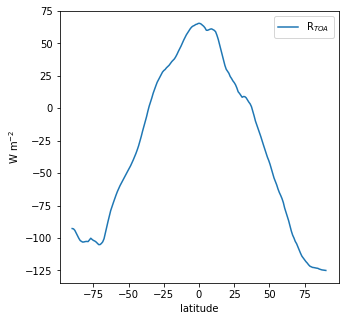

In [5]:
R_TOA = rsdt-rsut-rlut
R_TOA_zonal_time_mean = R_TOA.mean(dim=('time','lon'))

w = np.cos(np.deg2rad(lat))
gm = np.nansum(w*R_TOA_zonal_time_mean)/np.nansum(w)
R_TOA_zonal_time_mean=R_TOA_zonal_time_mean-gm

plt.figure(figsize=(5,5))
plt.plot(lat,R_TOA_zonal_time_mean,label='R$_{TOA}$')
plt.xlabel('latitude')
plt.ylabel('W m$^{-2}$')
plt.legend()

**What does this plot imply about heat transport in the climate system? Remember this plot shows where energy is converging and where it is diverging!**

<b> Answer: </b>

<div class="alert alert-block alert-warning">
Heat is transported away from the equator toward the poles as there is a postive sign in the tropics (divergence) and negative sign inat the poles (convergence).

</div>

Now, let's calculate the heat transport using the provided function above. Place the `R_TOA_zonal_time_mean` as the first argument, `lat` as the second argument, and `0` as the last argument. Name the variable `H`.

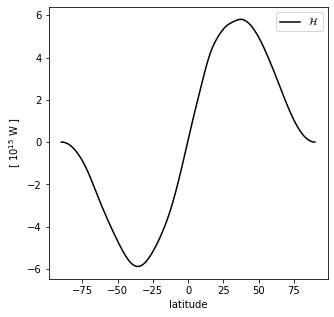

In [6]:
# --- code ---

H = inferred_heat_transport(R_TOA_zonal_time_mean, lat, 0)

plt.figure(figsize=(5,5))
plt.plot(lat,H,label='$\mathcal{H}$',c='k')
plt.xlabel('latitude')
plt.ylabel('[ 10$^{15}$ W ]')
plt.legend()

**How does this plot relate to the last one? What does it show? Where is the peak heat transport in each hemisphere and why?**

<b> Answer: </b>

<div class="alert alert-block alert-warning">
This plot shows the direction and the magnitude of meridional heat transport done by the atmosphere and ocean. In the Southern Hemisphere, $H$ is always negative, meaning that heat is always transported to the south pole. In the Northenrn Hemisphere, $H$ is always positive, meaning that heat is always transport to the north pole. The peak occurs where the absorbed shortwave radiation is equal to the outgoing longwave radiation.
</div>

Now, that we have total heat transport by both the ocean and atmosphere, we can seperate the two. To do this, we are going to look at the energy budget of the surface. We will need to import the shortwave and longwave components and the sensible and latent heat components. By now you should be familiar with shortwave and longwave radiation. The sensible and latent heat components are determined through the gradients of temperature and moisture near the surface. Sensible and latent heat fluxes involve turbulent exchanges in the planetary boundary layer. We will look at these in more detail later. Let's import all of them.

In [7]:
filepath = 'rlds_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
lon=file['lon']
lat=file['lat']
rlds=file['rlds']

filepath = 'rlus_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
rlus=file['rlus']

filepath = 'rldscs_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
rldscs=file['rldscs']

filepath = 'rsus_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
rsus=file['rsus']

filepath = 'rsds_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
rsds=file['rsds']

filepath = 'rsuscs_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
rsuscs=file['rsuscs']

filepath = 'rsdscs_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
rsdscs=file['rsdscs']

filepath = 'hfls_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
hfls=file['hfls']

filepath = 'hfss_Amon_CESM2_01_12_1981_2012.nc'
file = xr.open_dataset(filepath)
hfss=file['hfss']

**Write out the surface energy budget and plot the annual-mean net surface heat flux. Name this variable `Fs` and `Fs_annual`.**

In [8]:
# --- code ---
Fs = (rsds-rsus)-(rlus-rlds)-hfls-hfss
Fs_annual = Fs.mean('time')

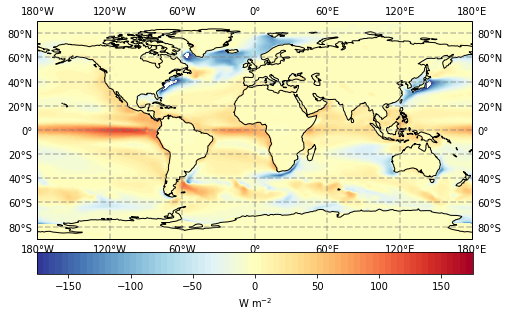

In [9]:
cylindrical_equidistant_projection(lat,lon,Fs_annual,np.arange(-175,180,5),np.arange(-250,300,50),cmap='RdYlBu_r',c_label='W m$^{-2}$',title='',fig=None,ax=None)

**Describe key feautres of the neat surface heat flux. Where is heat going into the ocean and where is it leaving the ocean?**

<b> Answer: </b>

<div class="alert alert-block alert-warning">
Heat enters the ocean at the equator largely because of the cold water that upwells from the deep ocean at the equator. Heat leaves the ocean along teh western boundary currents and in the subpolar gyres as this is where warm water sits beneath a cold atmosphere that draws heat out. This largely occurs in the winter when cold continental air flows over warm ocean water.
</div>

Now, let's explore seasonal variations.

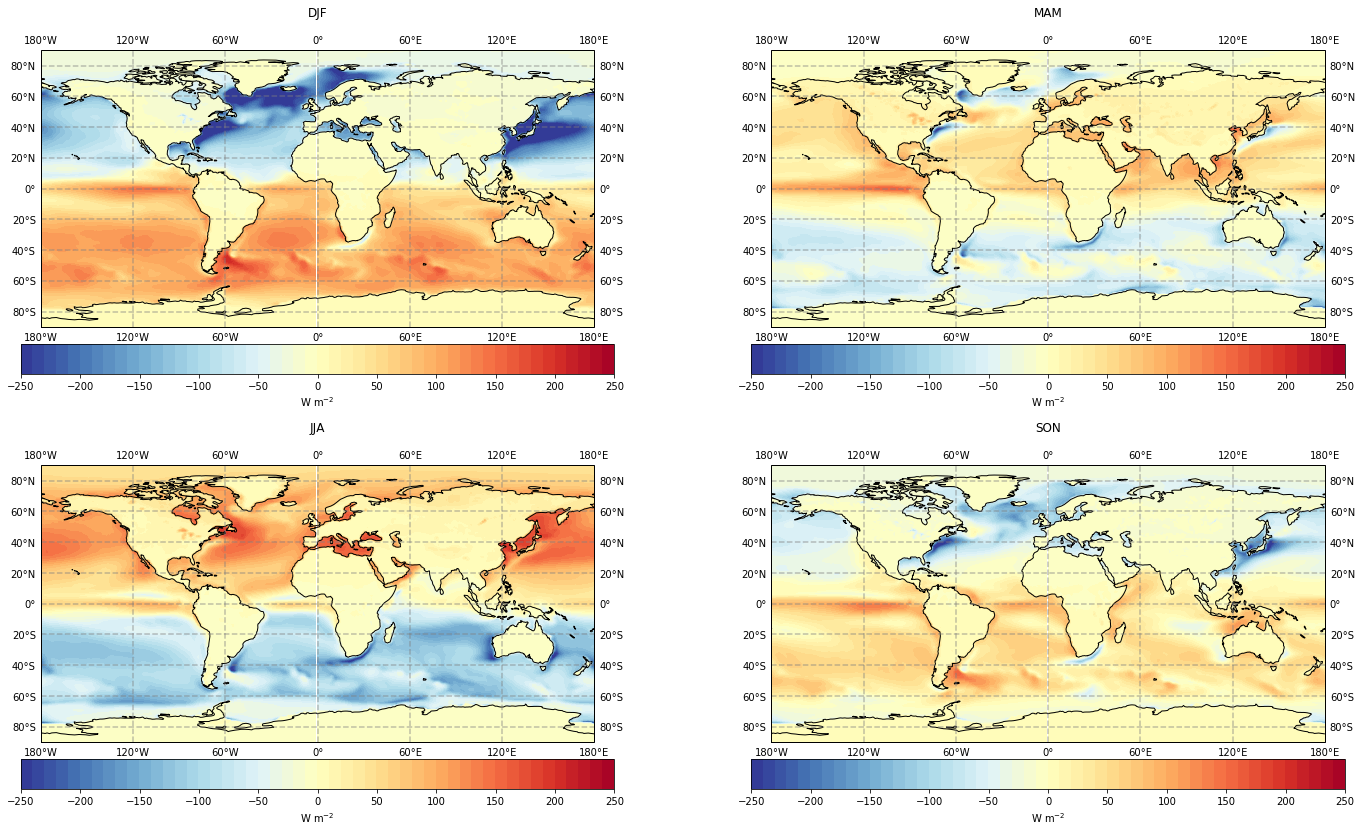

In [10]:
Fs_seasonal = Fs.groupby('time.season').mean() # group by season (DJF, MAM, JJA, SON) and take the (seasonal) mean
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,14), subplot_kw={'projection': ccrs.PlateCarree()})
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    seas_data = Fs_seasonal.sel(season=season)
    seas_data=np.array(seas_data)
    seas_data[seas_data<-250]=-250
    seas_data[seas_data>250]=250
    cylindrical_equidistant_projection(lat,lon,seas_data,np.arange(-250,260,10),np.arange(-250,300,50),cmap='RdYlBu_r',c_label='W m$^{-2}$',title=season,fig=fig,ax=axes.flatten()[i]) # plot

**What is going on seasonally? Where is heat going into the ocean and where is it leaving the ocean? Why do you think this is?**

<b> Answer: </b>

<div class="alert alert-block alert-warning">
In both hemispheres, heat is entering the ocean during the summertime, and heat is leaving the ocean during the wintertime. Largely, this is because you are seeing cold air move over a warm ocean that pulls heat out in the winter and during the summer you see a colder ocean surface beneath a warmer atmosphere that draws heat in.

</div>

**Now, explain what terms are contributing to these seasonal variations. To do this, create seasonal averages of the sensible heat flux (`hfss`), latent heat flux (`hfls`), net shortwave radiation (`rsds-rsus`), and net longwave radiation (`rlds-rlus`).** 

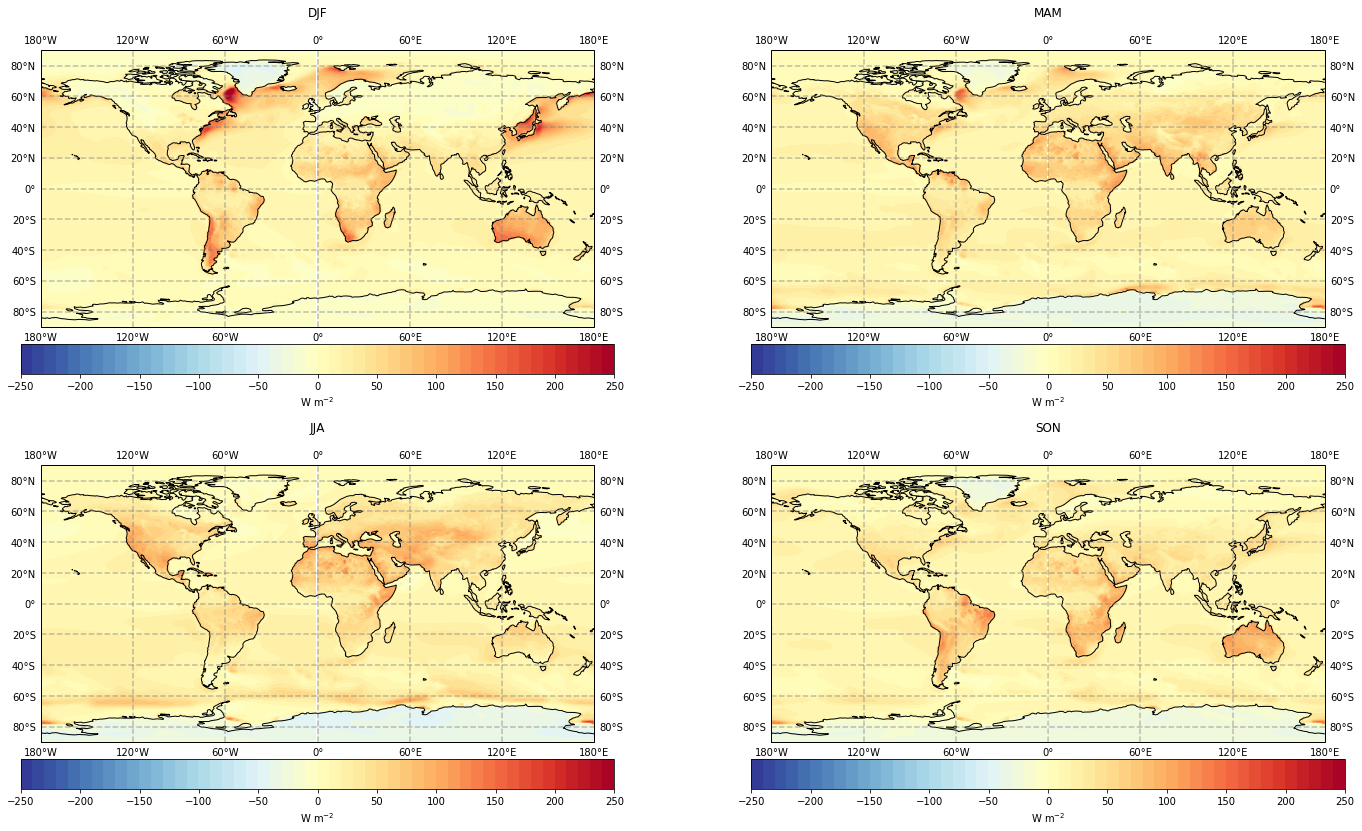

In [11]:
SH_seasonal = hfss.groupby('time.season').mean() # group by season (DJF, MAM, JJA, SON) and take the (seasonal) mean
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,14), subplot_kw={'projection': ccrs.PlateCarree()})
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    seas_data = SH_seasonal.sel(season=season)
    seas_data=np.array(seas_data)
    seas_data[seas_data<-250]=-250
    seas_data[seas_data>250]=250
    cylindrical_equidistant_projection(lat,lon,seas_data,np.arange(-250,260,10),np.arange(-250,300,50),cmap='RdYlBu_r',c_label='W m$^{-2}$',title=season,fig=fig,ax=axes.flatten()[i]) # plot


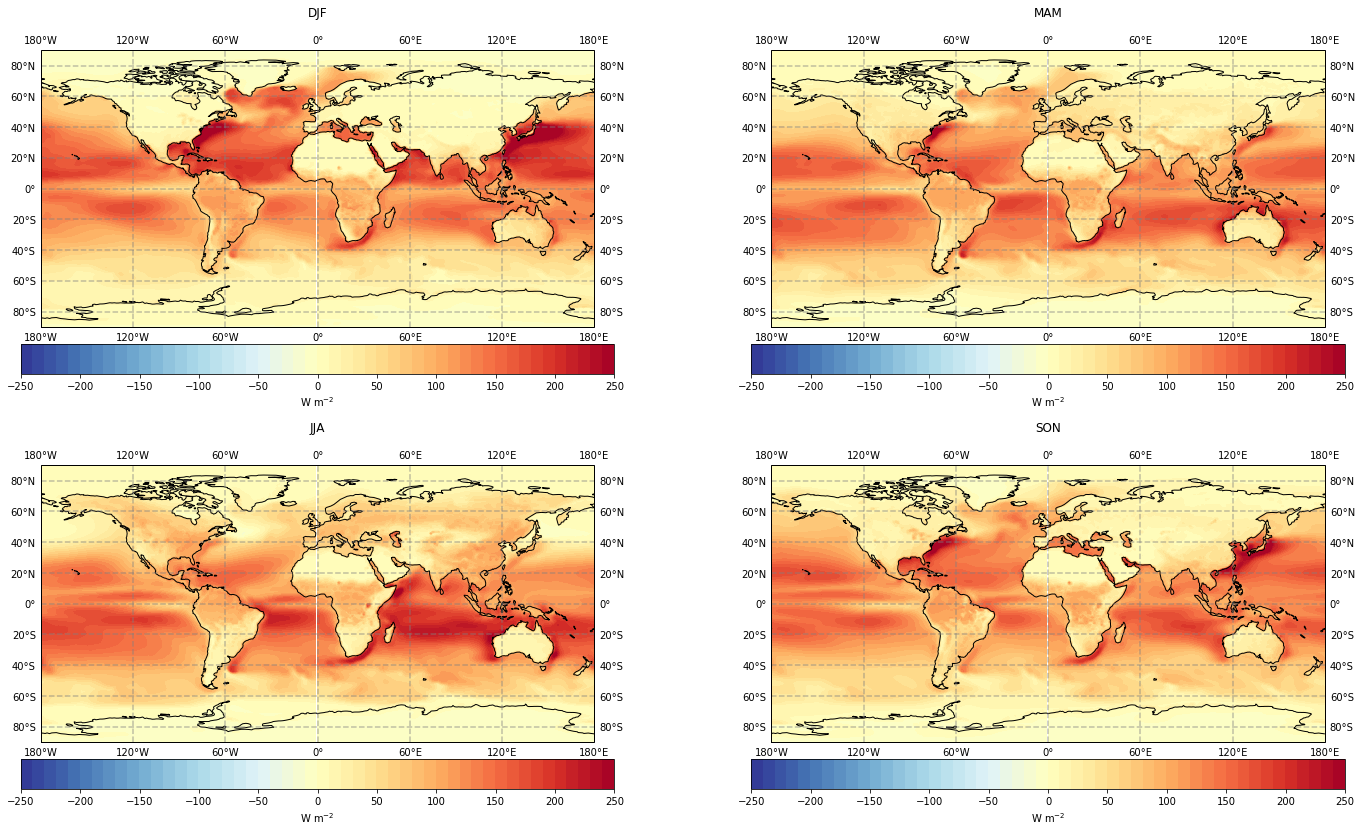

In [12]:
LH_seasonal = hfls.groupby('time.season').mean() # group by season (DJF, MAM, JJA, SON) and take the (seasonal) mean
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,14), subplot_kw={'projection': ccrs.PlateCarree()})
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    seas_data = LH_seasonal.sel(season=season)
    seas_data=np.array(seas_data)
    seas_data[seas_data<-250]=-250
    seas_data[seas_data>250]=250
    cylindrical_equidistant_projection(lat,lon,seas_data,np.arange(-250,260,10),np.arange(-250,300,50),cmap='RdYlBu_r',c_label='W m$^{-2}$',title=season,fig=fig,ax=axes.flatten()[i]) # plot

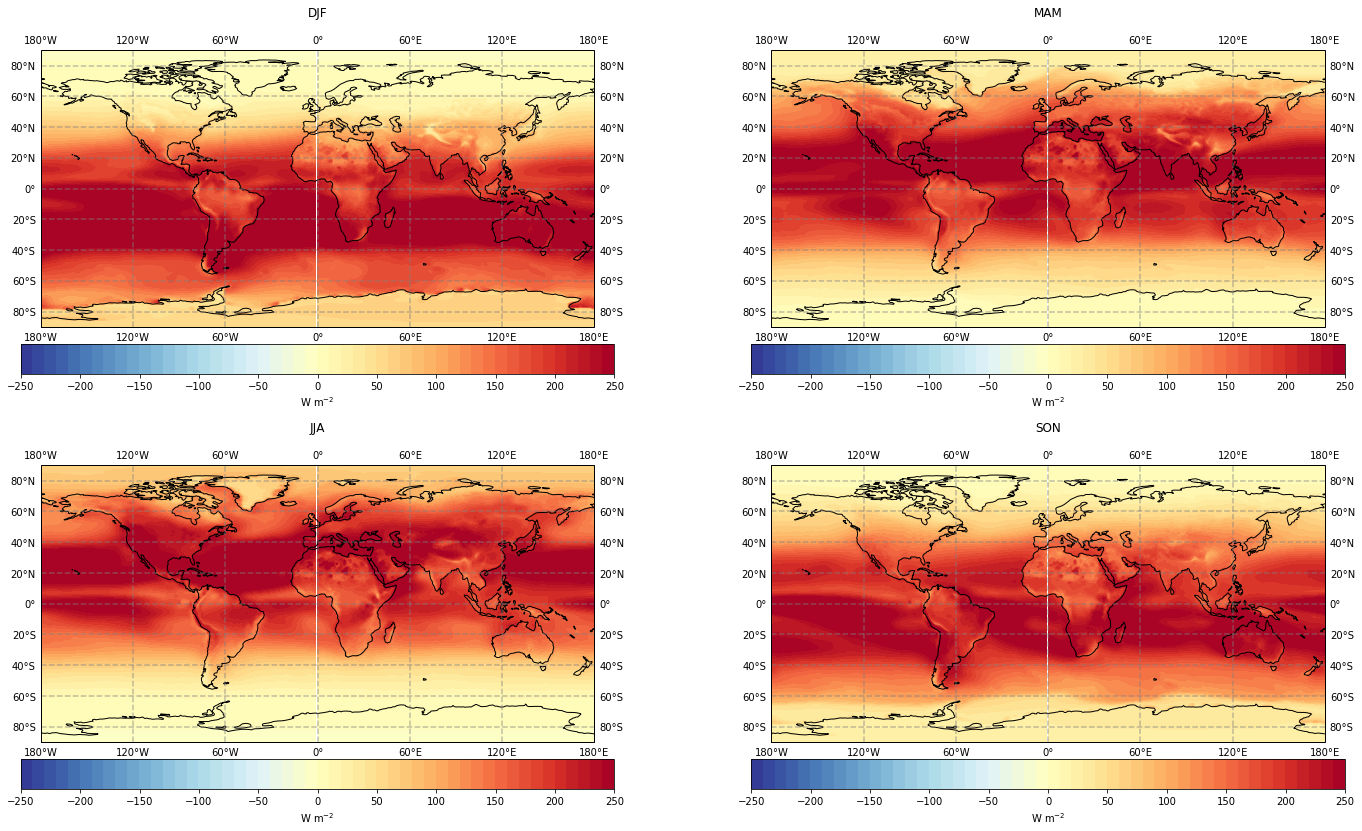

In [13]:
SW_seasonal = (rsds-rsus).groupby('time.season').mean() # group by season (DJF, MAM, JJA, SON) and take the (seasonal) mean
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,14), subplot_kw={'projection': ccrs.PlateCarree()})
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    seas_data = SW_seasonal.sel(season=season)
    seas_data=np.array(seas_data)
    seas_data[seas_data<-250]=-250
    seas_data[seas_data>250]=250
    cylindrical_equidistant_projection(lat,lon,seas_data,np.arange(-250,260,10),np.arange(-250,300,50),cmap='RdYlBu_r',c_label='W m$^{-2}$',title=season,fig=fig,ax=axes.flatten()[i]) # plot


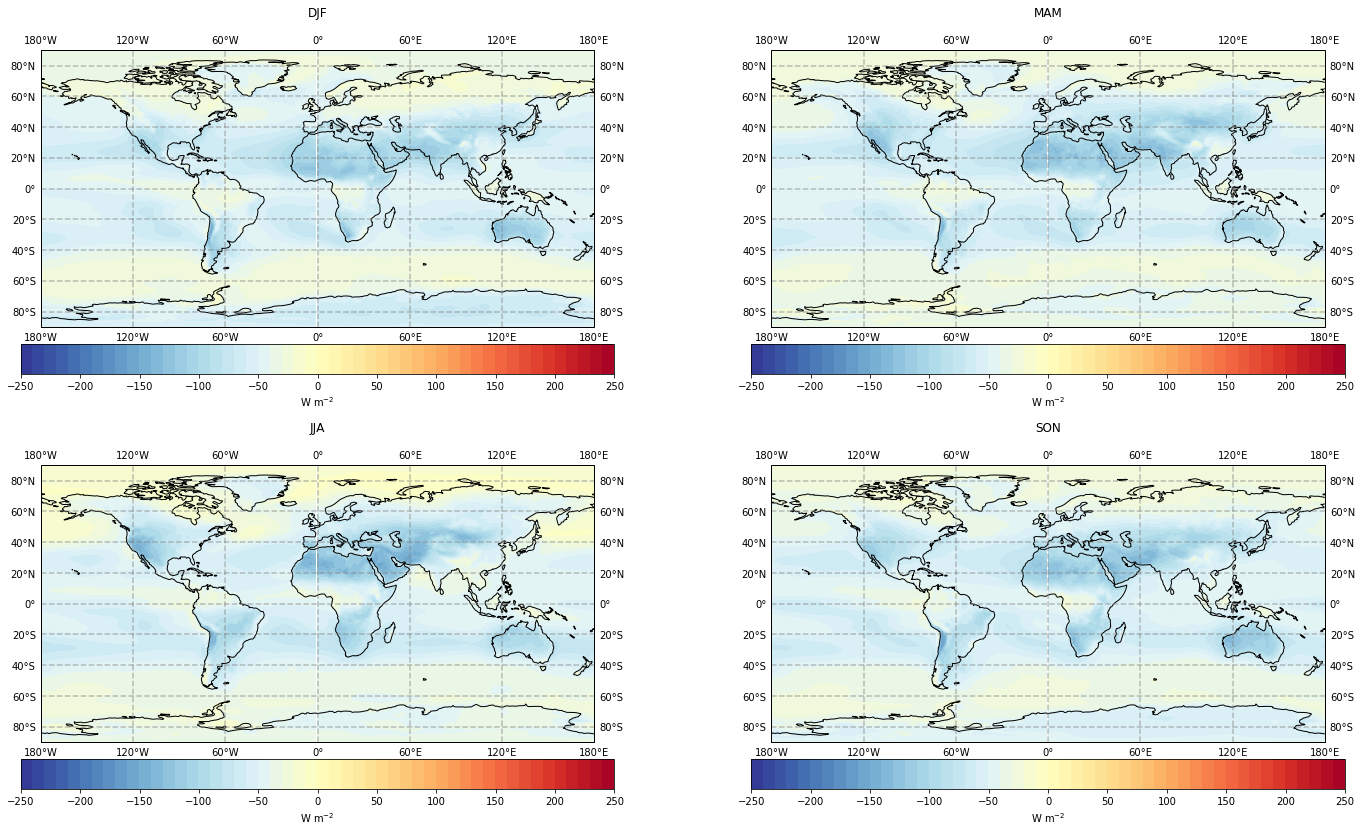

In [14]:
LW_seasonal = (rlds-rlus).groupby('time.season').mean() # group by season (DJF, MAM, JJA, SON) and take the (seasonal) mean
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,14), subplot_kw={'projection': ccrs.PlateCarree()})
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    seas_data = LW_seasonal.sel(season=season)
    seas_data=np.array(seas_data)
    seas_data[seas_data<-250]=-250
    seas_data[seas_data>250]=250
    cylindrical_equidistant_projection(lat,lon,seas_data,np.arange(-250,260,10),np.arange(-250,300,50),cmap='RdYlBu_r',c_label='W m$^{-2}$',title=season,fig=fig,ax=axes.flatten()[i]) # plot


<b> Answer: </b>

<div class="alert alert-block alert-warning">
The above plots show that sensible heat flux that the sensible heat pattern is very distinct in the winter, with strong sensible heat flux at the western boundary currents that are the result of a gradient between atmospheric temperatures and near-surface temperatures. The latent heat has a very spatial similar structure to seasonal temperature changes since this largely follows evaporation, which is closely tied to temperature. This also occurs because of the gradient in moisture near the surface and the overlying atmosphere. The net shortwave radiation is strongest during each hemisphere summer. Finally, the net longwave radiaiton is also very uniform through out the globe because the surface temperature does not have too much variation zonally and mainly has variations meridionally.
</div>

Now, similar to before we can use the surface energy budget to calculate the heat transport by the atmosphere and ocean. The total transport (which we have been inferring from the TOA radiation imbalance) includes contributions from both the **atmosphere** and the **ocean**:

$$ \mathcal{H} = \mathcal{H}_{a} + \mathcal{H}_{o} $$

We have used the **TOA imbalance** to infer the total transport because TOA radiation is the only significant energy source / sink to the climate system as a whole.

However, if we want to study (or model) the individual contributions from the atmosphere and ocean, we need to consider the energy budgets for **each individual domain**.

#### Energy budget for the ocean

Using exactly the same reasoning we used for the whole climate system, we can write a budget for the ocean as:

$$ \frac{\partial E_o}{\partial t} = F_S - \frac{1}{2 \pi a^2  \cos⁡\phi } \frac{\partial \mathcal{H_o}}{\partial \phi} $$

Assuming that

- surface fluxes are well-known
- the ocean heat storage is negligible

we can write

$$ \mathcal{H}_o(\phi) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ F_S d\phi^\prime  $$

This represents the transport of heat by the ocean.

#### Energy budget for the atmosphere

The net energy source to the atmosphere is the sum of the TOA flux and the surface flux. Thus we can write

$$ \frac{\partial E_a}{\partial t} = R_{TOA} - F_S - \frac{1}{2 \pi a^2  \cos⁡\phi } \frac{\partial \mathcal{H_a}}{\partial \phi} $$

and we can similarly integrate to get the transport:

$$ \mathcal{H}_a(\phi) = 2 \pi ~a^2 \int_{-\pi/2}^{\phi} \cos⁡\phi^\prime ~ \big( R_{TOA} - F_S \big) d\phi^\prime  $$

Note that these formulas ensure that $\mathcal{H} = \mathcal{H}_a + \mathcal{H}_o$.

Now, using the expression and function above calculate the ocean and atmopshere heat transport. To do this, first calculate the time- and zonal- mean. Then remove the global-mean value to ensure the model is in balance (remember to area weight). Then calcualte the heat transport of the atmosphere and ocean and add it to the total heat transport plot. Name these variables `Fs_z` and `R_TOA_z` and the heat transport variables `H_a` and `H_o`.

In [15]:
R_TOA_z = R_TOA.mean(dim=('time','lon'))

w = np.cos(np.deg2rad(lat))
gm = np.nansum(w*R_TOA_z)/np.nansum(w)
R_TOA_z=R_TOA_z-gm


Fs_z = Fs.mean(dim=('time','lon'))

w = np.cos(np.deg2rad(lat))
gm = np.nansum(w*Fs_z)/np.nansum(w)
Fs_z=Fs_z-gm

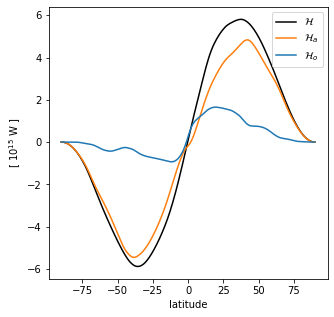

In [16]:
plt.figure(figsize=(5,5))

Ha = inferred_heat_transport(R_TOA_z-Fs_z, lat, 0)
Ho = inferred_heat_transport(Fs_z, lat, 0)


plt.plot(lat,H,label='$\mathcal{H}$',c='k')
plt.plot(lat,Ha,label='$\mathcal{H}_a$',c='C1')
plt.plot(lat,Ho,label='$\mathcal{H}_o$',c='C0')

plt.xlabel('latitude')
plt.ylabel('[ 10$^{15}$ W ]')
plt.legend()

#### Investigating the cloud radiative effects at the surface

Finally, like before let's explore the influence of clouds on the surface energy budget. Before, we looked at how clouds affect radiation at the top-of-atmosphere, but here we are interested in how the affect the surface. We have already imported the clear sky fluxes. Calculate the shortwave and longwave coud radiative effect and plot the annual-mean. Also, plot the net cloud radiative effect (i.e., the sum of the longwave and shortwave components). For example, the shortwave cloud radiative effect is: `(rsds-rsus)-(rsdscs-rsuscs)`.

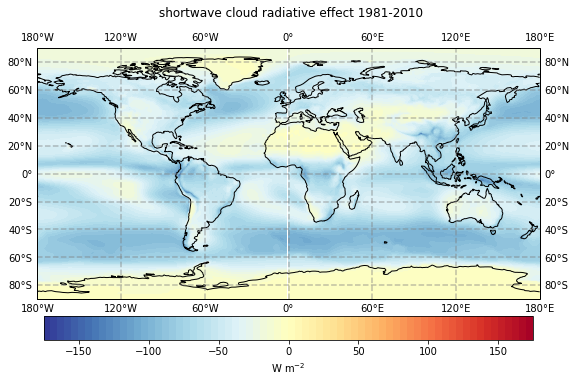

In [17]:
# --- code ---
SWclouds = (rsds-rsus)-(rsdscs-rsuscs)
fig = plt.figure(figsize=(9,6))
SWclouds_annual = SWclouds.mean('time')
title = ' shortwave cloud radiative effect 1981-2010'
cylindrical_equidistant_projection(lat,lon,SWclouds_annual,np.arange(-175,180,5),np.arange(-250,300,50),cmap='RdYlBu_r',c_label='W m$^{-2}$',title=title,fig=fig)


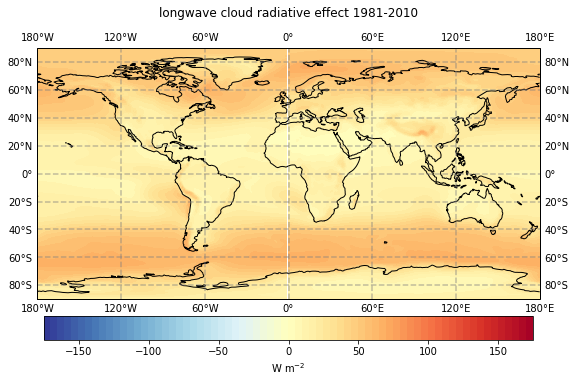

In [18]:
LWclouds = rlds-rldscs
fig = plt.figure(figsize=(9,6))
LWclouds_annual = LWclouds.mean('time')
title = 'longwave cloud radiative effect 1981-2010'
cylindrical_equidistant_projection(lat,lon,LWclouds_annual,np.arange(-175,180,5),np.arange(-250,300,50),cmap='RdYlBu_r',c_label='W m$^{-2}$',title=title,fig=fig)

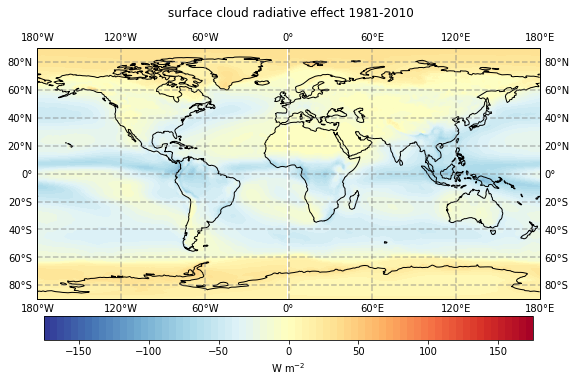

In [19]:
net = SWclouds+LWclouds
fig = plt.figure(figsize=(9,6))
net_annual = net.mean('time')
title = ' surface cloud radiative effect 1981-2010'
cylindrical_equidistant_projection(lat,lon,net_annual,np.arange(-175,180,5),np.arange(-250,300,50),cmap='RdYlBu_r',c_label='W m$^{-2}$',title=title,fig=fig)


**Where do clouds warm the planet and where do they cool the planet? What does the spatial distrubtion look like? Why is there a narrow band at the equator? What is going on off the coast of Chile and California?**

<b> Answer: </b>

<div class="alert alert-block alert-warning">
The net cloud radiative effect (CRE) is negative globally, but warms the arctic and antarctic regions. The thin band at the equator is the ITCZ. This occurs because of the rising branch of the Hadley cell circulation which develops clouds that reflect solar radiation back to space and cool the surface. Along the coast of Chile and California there is a very strong cloud radiative cooling effect. This is because of the large stratocumuls cloud decks that hug the coast. These regions are important for understanding global climate change as they will determine the magnitude of cloud feedbacks.
</div>